# Step 1 : importing Essential Libraries

In [97]:
# !pip install -q keras
# !pip install -q numpy
# !pip install -q pandas
# !pip install -q matplotlib
# !pip install -q scikit-learn
# !pip install -q Pillow
# !pip install -q seaborn
# !pip install -q scikeras
# !pip install -q imbalanced-learn
# !pip install -q catboost
# !pip install -q cv2
# !pip install -q opencv-python
# !pip install -q shap

In [1]:
import os
import tensorflow as tf
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier
from keras_applications.resnet50 import ResNet50
from keras import backend as K

warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set the GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth must be set before creating a GPU device
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [3]:
IMG_SIZE = 32,32
BATCH_SIZE = 8
SEED = 55
AUTO = tf.data.AUTOTUNE

# Step 2 : Loading pictures and making Dictionary of images and labels

In [100]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
data_path = 'G:\\HSUHK\\COM6003\\project\\archive\\'
img_path = 'G:\\HSUHK\\COM6003\\project\\archive\\imgs\\'

In [7]:
df = pd.read_csv(os.path.join(data_path, 'metadata.csv'))
df.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NaN,NEV,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,BCC,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,NaN,ACK,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,...,NaN,ACK,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,BCC,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,PAT_684_1302_588.png,True


In [8]:
df['full_link'] = img_path + df['img_id']

In [9]:
df['encoded_class'] = df['diagnostic'].map({'BCC':0,'ACK':1,'NEV':2,'SEK':3,'SCC':4,'MEL':5})

In [10]:
df['encoded_class'].value_counts()

encoded_class
0    845
1    730
2    244
3    235
4    192
5     52
Name: count, dtype: int64

In [11]:
df.drop([ 'biopsed','patient_id', 'img_id','lesion_id','smoke', 'drink', 'background_father', 'background_mother', 'pesticide', 'gender', 'skin_cancer_history',
         'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2','diagnostic'], axis = 1, inplace = True)

In [12]:
df.isnull().mean()

age              0.0
region           0.0
itch             0.0
grew             0.0
hurt             0.0
changed          0.0
bleed            0.0
elevation        0.0
full_link        0.0
encoded_class    0.0
dtype: float64

In [13]:
image_data=df[['full_link','encoded_class']]

In [14]:
image_data.head()

,full_link,encoded_class
0,G:\HSUHK\COM6003\project\archive\imgs\PAT_1516...,2
1,G:\HSUHK\COM6003\project\archive\imgs\PAT_46_8...,0
2,G:\HSUHK\COM6003\project\archive\imgs\PAT_1545...,1
3,G:\HSUHK\COM6003\project\archive\imgs\PAT_1989...,1
4,G:\HSUHK\COM6003\project\archive\imgs\PAT_684_...,0


In [15]:
diagnostic_classes = {0:'BCC', 1 : 'ACK', 2 : 'NEV', 3 : 'SEK', 4 : 'SCC', 5: 'MEL'}

In [16]:
x = image_data['full_link']
y = image_data['encoded_class']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=SEED)

In [17]:
# train_image=image_data[:2000]
# test_image=image_data[2000:]

In [18]:
# train_image

,full_link,encoded_class
0,G:\HSUHK\COM6003\project\archive\imgs\PAT_1516...,2
1,G:\HSUHK\COM6003\project\archive\imgs\PAT_46_8...,0
2,G:\HSUHK\COM6003\project\archive\imgs\PAT_1545...,1
3,G:\HSUHK\COM6003\project\archive\imgs\PAT_1989...,1
4,G:\HSUHK\COM6003\project\archive\imgs\PAT_684_...,0
...,...,...
1995,G:\HSUHK\COM6003\project\archive\imgs\PAT_1216...,1
1996,G:\HSUHK\COM6003\project\archive\imgs\PAT_367_...,4
1997,G:\HSUHK\COM6003\project\archive\imgs\PAT_570_...,4
1998,G:\HSUHK\COM6003\project\archive\imgs\PAT_570_...,0


In [20]:
def create_datagen(train_df, val_df, test_df, train_dir, val_dir, test_dir, img_size=(256, 256), batch_size=16, class_mode='categorical'):
    """ Create data generators for training, validation, and testing datasets. """
    def img_preprocessing(image_path, label):
        """ Image preprocessing function """
        img = tf.io.read_file(image_path)  # Read the image file
        img = tf.image.decode_png(img, channels=3)  # Decode the JPEG image
        img = tf.image.resize(img, img_size)  # Resize the image
        img = tf.cast(img, tf.float32) / 255.0  # Normalize pixel values to [0, 1] range

        if class_mode == 'categorical':
            label = tf.one_hot(tf.strings.to_number(label, out_type=tf.int32), depth=6)  # Convert labels to one-hot encoding
        else:
            label = tf.strings.to_number(label, out_type=tf.int32)
        return img, label

    def augmentation(image, label):
        """ Data augmentation function """
        image = tf.image.random_flip_left_right(image)  # Randomly flip the image horizontally
        image = tf.image.random_flip_up_down(image)  # Randomly flip the image vertically

        def numpy_rotation(image):
            image = tf.keras.utils.img_to_array(image)  # Convert the tensor to a numpy array
            image = tf.keras.preprocessing.image.random_rotation(image, 0.2)  # Randomly rotate the image
            return image

        image = tf.py_function(numpy_rotation, [image], tf.float32)
        image.set_shape((img_size[0], img_size[1], 3))

        image = tf.image.random_brightness(image, max_delta=0.2)  # Randomly adjust brightness
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Randomly adjust contrast
        return image, label

    # Create dataset loaders and tf.datasets
    train_loader = tf.data.Dataset.from_tensor_slices((tf.strings.join([train_dir,train_df['img_id']],separator='\\'), 
                                                       train_df.drop(columns=['img_id'])))
    train_dataset = (train_loader
                     .map(img_preprocessing, num_parallel_calls=AUTO)  # Apply image preprocessing function
                     .map(augmentation, num_parallel_calls=AUTO)  # Apply data augmentation function
                     .batch(batch_size)  # Batch the data
                     .shuffle(batch_size * 10)  # Shuffle the dataset
                     .prefetch(AUTO))  # Prefetch data for performance

    val_loader = tf.data.Dataset.from_tensor_slices((tf.strings.join([val_dir,val_df['img_id']],separator='\\'), 
                                                     val_df.drop(columns=['img_id'])))
    val_dataset = (val_loader
                   .map(img_preprocessing, num_parallel_calls=AUTO)  # Apply image preprocessing function
                   .batch(batch_size)  # Batch the data
                   .prefetch(AUTO))  # Prefetch data for performance

    test_loader = tf.data.Dataset.from_tensor_slices((tf.strings.join([test_dir,test_df['img_id']],separator='\\'), 
                                                      test_df.drop(columns=['img_id'])))
    test_dataset = (test_loader
                    .map(img_preprocessing, num_parallel_calls=AUTO)  # Apply image preprocessing function
                    .batch(batch_size)  # Batch the data
                    .prefetch(AUTO))  # Prefetch data for performance

    return train_dataset, val_dataset, test_dataset

Found 2000 validated image filenames.
Found 298 validated image filenames.


In [18]:
# # Load in training pictures
# X_train = []
# y_train = []
# for index, row in train_image.iterrows():
#     filename = row['full_link']
#     label = row['encoded_class']
#     img = np.asarray(Image.open(filename).convert("RGB").resize((224, 224)))
#     X_train.append(img)
#     y_train.append(label)
# X_train = np.array(X_train, dtype='uint8')
# y_train = np.array(y_train)

# # Load in testing pictures
# X_test = []
# y_test = []
# for index, row in test_image.iterrows():
#     filename = row['full_link']
#     label = row['encoded_class']
#     img = np.asarray(Image.open(filename).convert("RGB").resize((224, 224)))
#     X_test.append(img)
#     y_test.append(label)
# X_test = np.array(X_test, dtype='uint8')
# y_test = np.array(y_test)

# # Shuffle data
# np.random.seed(42)
# indices = np.arange(X_train.shape[0])
# np.random.shuffle(indices)
# X_train = X_train[indices]
# y_train = y_train[indices]

# indices = np.arange(X_test.shape[0])
# np.random.shuffle(indices)
# X_test = X_test[indices]
# y_test = y_test[indices]

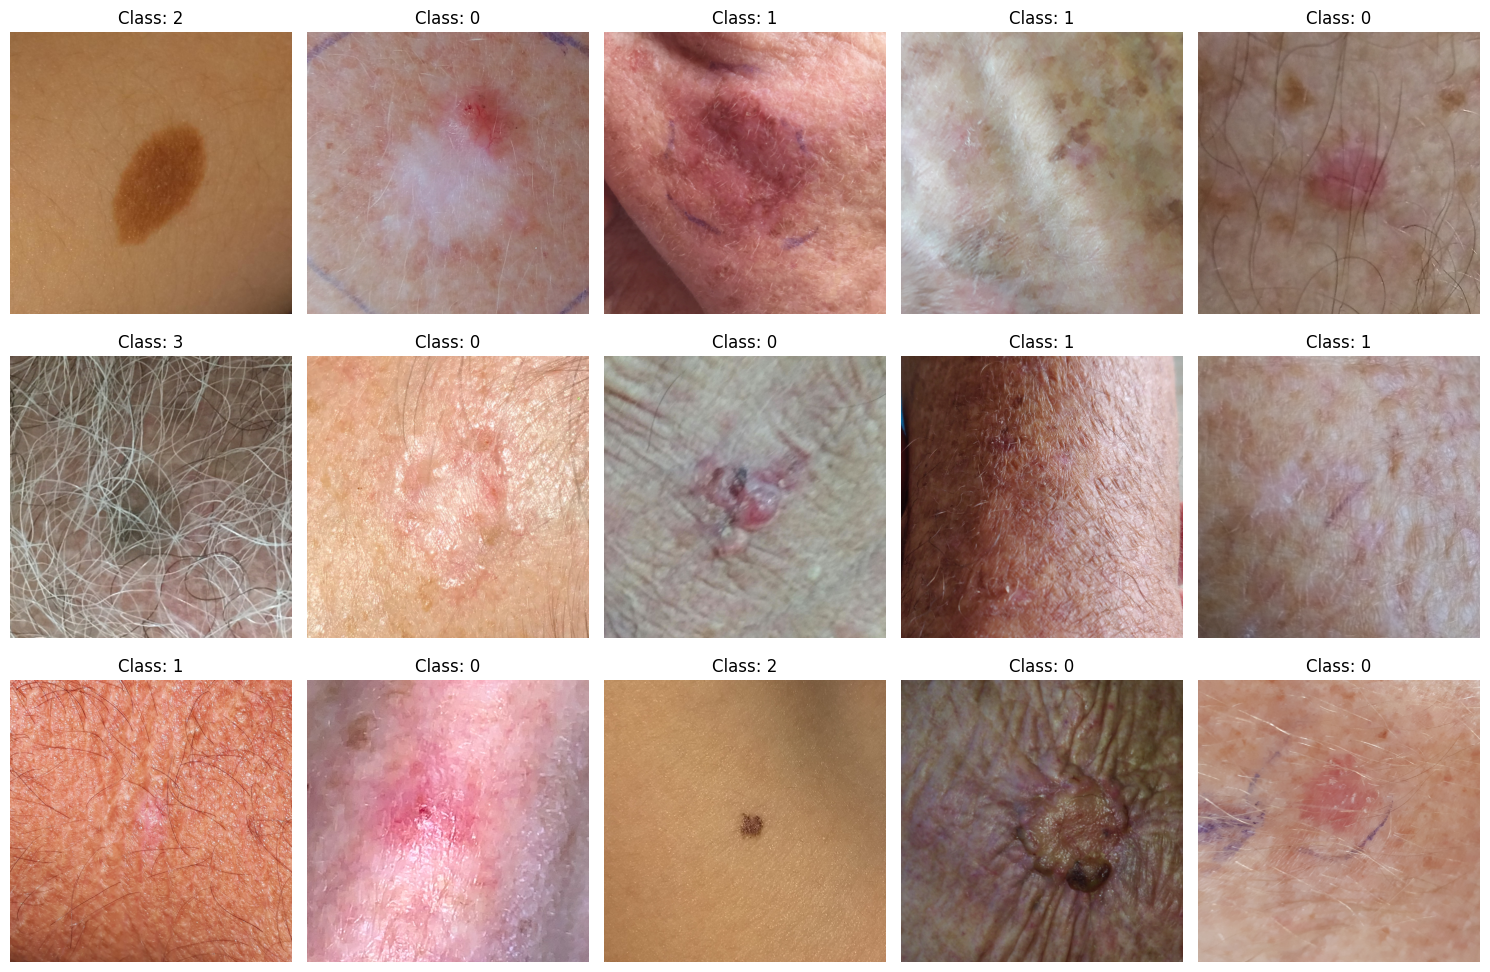

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 5, figsize=(15, 10))

for i, ax in enumerate(axs.flat):
    img = train_image.iloc[i]['full_link']
    label = train_image.iloc[i]['encoded_class']
    ax.imshow(plt.imread(img))
    ax.set_title(f'Class: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Step 3: Categorical Labels

In [20]:
# y_train = to_categorical(y_train, num_classes= 6)
# y_test = to_categorical(y_test, num_classes= 6)

# Step 4 : Normalization

In [21]:
# #Normalize all Values of the pictures by dividing all the RGB values by 255
# # With data augmentation to prevent overfitting
# X_train = X_train/255.
# X_test = X_test/255.

# Step 5: Model Building

In [26]:
def build(input_shape= (224,224,3), learning_rate= 1e-3,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(1, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    else:
        optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer = optimizer ,loss = "categorical_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 56, 56, 64)       

KeyError: 'val_accuracy'

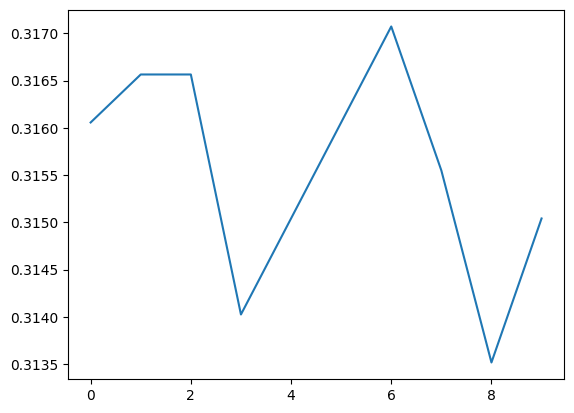

In [27]:
input_shape = (224,224,3)
learning_rate = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

model = build(learning_rate=learning_rate, init= init, activ= activ, optim=optim, input_shape= input_shape)

history = model.fit_generator(train_generator, epochs = 10, 
                    steps_per_epoch = train_steps, verbose=0,
                    callbacks=[learning_rate_reduction]
                   )
model.save(data_path+"model_6_classified.h5")
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
# K.clear_session()
# del model
# del history

# Step 6: Cross-Validating Model

In [25]:
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []
for train, test in kfold.split(X_train, y_train):
  # create model
    model = build(learning_rate=learning_rate,
                  init= init,
                  activ= activ,
                  optim=optim,
                  input_shape= input_shape)

    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 56, 56, 64)       

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_1/max_pooling2d_2/MaxPool/MaxPoolGrad' defined at (most recent call last):
    File "e:\Anaconda\envs\tensorflow\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "e:\Anaconda\envs\tensorflow\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "e:\Anaconda\envs\tensorflow\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "e:\Anaconda\envs\tensorflow\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "e:\Anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\geyux\AppData\Local\Temp\ipykernel_14872\3240487072.py", line 14, in <module>
      model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=0)
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "e:\Anaconda\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_1/max_pooling2d_2/MaxPool/MaxPoolGrad'
OOM when allocating tensor with shape[64,224,224,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_1/max_pooling2d_2/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_9239]

# Step 7: Testing the model

In [ ]:
# Fitting model to all data
model = build(learning_rate=learning_rate,
              init= init,
              activ= activ,
              optim=optim,
              input_shape= input_shape)

model.fit(X_train, y_train,
          epochs=epochs, batch_size= batch_size, verbose=0,
          callbacks=[learning_rate_reduction]
         )


In [ ]:
# Predict probabilities for test data
y_pred_proba = model.predict(X_test)

# Get predicted class labels
y_pred = np.argmax(y_pred_proba, axis=1)

# Evaluate accuracy
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print("Accuracy: ", accuracy)

In [ ]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.weights.h5")
print("Saved model to disk")

# Clear memory, because of memory overload
# del model
# K.clear_session()

In [ ]:
del model
K.clear_session()

# Step 8: ResNet50

In [ ]:
from keras.callbacks import EarlyStopping
input_shape = (224,224,3)
lr = 1e-5
epochs = 43  ##学习到第43次时，验证集上的准确率最高。
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=6)

model.compile(optimizer = Adam(lr) ,
              loss = "categorical_crossentropy",
              metrics=["accuracy"])
# Add early stopping callback  加上后效果更差
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2,
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())


In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Train ResNet50 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=0,
          callbacks=[learning_rate_reduction]
         )

In [ ]:
# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

In [ ]:
# save model
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)

# serialize weights to HDF5
model.save_weights("resnet50.weights.h5")
print("Saved model to disk")

# PCA 图像数据，与文本结合

In [ ]:
# Train dataset without shuffle and augmentation
# image_data=df[['patient_id','full_link','encoded_class']]

def img_preprocessing(image, label):
    try:
        img = tf.io.read_file(image)
        img = tf.io.decode_png(img, channels=3)
        img = tf.image.resize(img, size=IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        return img, label
    except Exception as e:
        print(f"Error processing image {image}: {e}")
        return None, None


train_loader_for_feature = tf.data.Dataset.from_tensor_slices((train_image['full_link'], train_image['encoded_class']))
train_dataset_for_feature = (train_loader_for_feature
                             .map(img_preprocessing, num_parallel_calls = AUTO)
                             .batch(64)
                             .prefetch(AUTO))

In [ ]:
# Extract features from train_dataset
from tensorflow.keras.models import load_model
model= load_model('/content/drive/MyDrive/model_6_classified.h5')
train_features = model.predict(train_dataset_for_feature, verbose=1)


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_ = PCA()
pred_pca = pca_.fit_transform(train_features)


# Calculate the explained variance ratio for each component
explained_variance_ratio = pca_.explained_variance_ratio_

# Plot the explained variance ratio as a function of the number of components
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Method for PCA')
plt.grid()
plt.show()

In [ ]:
# Applying PCA components nearly equal to 0.98 variance ratio
from sklearn.decomposition import PCA
pca_ = PCA(4)
pred_pca = pca_.fit_transform(train_features)

new_feature_column_names = []
for i in range(pred_pca.shape[1]):
    new_feature_column_names.append('feature_{0}'.format(i+1))

pred_pca = pd.DataFrame(pred_pca, columns = new_feature_column_names)


# Features created with ConvMixer feature extractor
pred_pca.head()

In [ ]:
# Merging the deep learning features with meta data features

train_data_last = pd.concat([train_data, pred_pca], axis = 1)
train_data_last.drop(['full_link'], axis = 1, inplace = True)
train_data_last.head()

In [ ]:
# 导入 RandomOverSampler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler


# 计算样本权重
sample_weights = compute_sample_weight('balanced', train_data_last['encoded_class'])

# 定义随机上采样对象
ros = RandomOverSampler(random_state=42)

# 少数类过采样
X_ros, y_ros = ros.fit_resample(train_data_last.drop('encoded_class', axis=1),
                                train_data_last['encoded_class'],
                                sample_weights=sample_weights)

# 将上采样后的数据与原始数据合并
train_data_last = pd.concat([X_ros, y_ros.to_frame()], axis=1)
train_data_last.columns = train_data_last.drop('encoded_class', axis=1).columns.tolist() + ['encoded_class']

# 查看各类别的样本数量
train_data_last['encoded_class'].value_counts()


In [ ]:
train_data_last.info()

In [ ]:
train_data_last.columns

In [ ]:
from catboost import CatBoostClassifier, Pool
y_train_data_last = train_data_last.pop('encoded_class')
X_train_data_last = train_data_last
cat_features = [ 'region', 'itch', 'grew', 'hurt', 'changed',
       'bleed', 'elevation']
train_pool = Pool(X_train_data_last, y_train_data_last, cat_features = cat_features)
cat_model = CatBoostClassifier(verbose = 250)
cat_model.fit(train_pool)

In [ ]:
test_data.isnull().mean()

In [ ]:
# Test set processing
# test feature exteaction -> applying PCA -> merging with metadata -> predictions of the catboost model
test_loader = tf.data.Dataset.from_tensor_slices((test_image['full_link'], test_image['encoded_class']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(64)
                .prefetch(AUTO))

test_pred = model.predict(test_dataset)

In [ ]:
test_pred_pca = pca_.fit_transform(test_pred)
test_pred_pca = pd.DataFrame(test_pred_pca, columns = new_feature_column_names)
test_data = test_data.reset_index(drop=True)
test_pred_pca = test_pred_pca.reset_index(drop=True)
test_data_last = pd.concat([test_data, test_pred_pca], axis=1)
test_data_last.drop(['full_link'], axis = 1, inplace = True)

In [ ]:
test_data_last

In [ ]:

y_test_data_last = test_data_last.pop('encoded_class')
X_test_data_last = test_data_last


test_pool = Pool(X_test_data_last, y_test_data_last, cat_features = cat_features)
pred_cat_test = cat_model.predict(test_pool)

In [ ]:
# Predictions and scores
from sklearn.metrics import mean_squared_error, accuracy_score

mse = mean_squared_error(y_test_data_last, pred_cat_test)
acc = accuracy_score(y_test_data_last, pred_cat_test)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Accuracy Score : {0:.2f} %'.format(acc*100))

In [ ]:
clf = classification_report(y_test_data_last, pred_cat_test, target_names = list(diagnostic_classes.values()))
print(clf)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_data_last, pred_cat_test)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(diagnostic_classes.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax,  cmap = 'RdPu', colorbar = False)